In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# IMDB dataset

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84131840/84125825 [==============================] - 1s 0us/step


In [4]:
# 디렉토리 탐색
os.listdir(dataset_dir)

['imdbEr.txt', 'test', 'imdb.vocab', 'train', 'README']

In [5]:
# /content/aclImdb/train
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)
"""
pos와 neg에는 텍스트 파일들이 있으며 영화 리뷰가 담겨있다
"""

['labeledBow.feat',
 'urls_pos.txt',
 'neg',
 'pos',
 'unsupBow.feat',
 'urls_unsup.txt',
 'unsup',
 'urls_neg.txt']

In [6]:
# 샘플 파일 읽기
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


# Load the dataset

In [7]:
# /content/aclImdb/train/unsup
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir) # 지정된 폴더와 아휘 디렉토리 폴더, 파일을 모두 삭제

In [8]:
# train 데이터셋
batch_size = 32
seed = 42

#80:20으로 train set, validation set 분리
#shuffle=False로 하거나 seed를 고정해야 교차되지 않음
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [9]:
# 하나의 배치 가져와 3개 샘플 확인
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [11]:
# 0은 negative, 1은 positive
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [12]:
# validation 데이터셋
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [14]:
# test 데이터셋
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


# Prepare the dataset for training

In [16]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data) # 소문자
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ') # <br /> 제거
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation), # 구두점 제거
                                  '')

In [17]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int', # 각 단어를 정수로 토큰화
    output_sequence_length=sequence_length)

In [18]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [19]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [20]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

In [22]:
# 각 숫자에 해당하는 단어
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [23]:
# 벡터화
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# Configure the dataset for performance

In [24]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
"""
cache: 해당 데이터셋이 반복되는 상황에서 RAM과 같이 빨리 사용할 수 있는 공간에 저장
prefetch: 데이터셋의 한 배치가 미리 준비되도록 하면 학습 속도를 향상시킨다
AUTOTUNE으로 할 경우 로드할 데이터의 양을 동적으로 정한다.
"""

# Create the model

In [25]:
embedding_dim = 16

In [26]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


# Loss function and optimizer

In [27]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

# Train the model

In [28]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 11s 16ms/step - loss: 0.6621 - binary_accuracy: 0.7030 - val_loss: 0.6121 - val_binary_accuracy: 0.7742
Epoch 2/10
625/625 [==============================] - 4s 6ms/step - loss: 0.5458 - binary_accuracy: 0.8034 - val_loss: 0.4960 - val_binary_accuracy: 0.8234
Epoch 3/10
625/625 [==============================] - 3s 6ms/step - loss: 0.4427 - binary_accuracy: 0.8461 - val_loss: 0.4187 - val_binary_accuracy: 0.8472
Epoch 4/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3772 - binary_accuracy: 0.8661 - val_loss: 0.3729 - val_binary_accuracy: 0.8616
Epoch 5/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3337 - binary_accuracy: 0.8803 - val_loss: 0.3443 - val_binary_accuracy: 0.8678
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3036 - binary_accuracy: 0.8903 - val_loss: 0.3253 - val_binary_accuracy: 0.8720
Epoch 7/10
625/625 [==============================] - 3s 5ms/s

# Evaluate the model

In [29]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 8s 11ms/step - loss: 0.3102 - binary_accuracy: 0.8732
Loss:  0.3101734519004822
Accuracy:  0.8731600046157837


# Create a plot of accuracy and loss over time

In [30]:
#histroy에 loss, accuracy, val_loss, va_acc 저장되어 있음
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

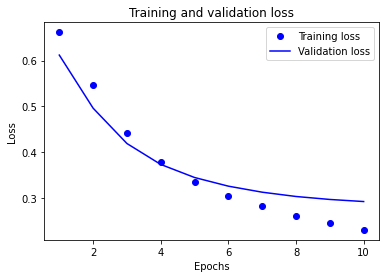

In [31]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

#loss plot 그리기
epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

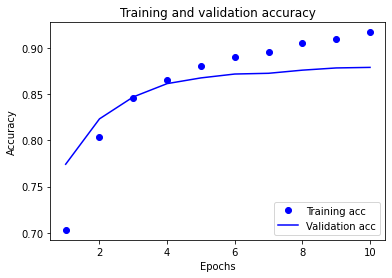

In [32]:
# Acc plot 그리기
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

# Export the model

In [33]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 9s 11ms/step - loss: 0.3102 - accuracy: 0.8732
0.8731600046157837


# Inference on new data

In [34]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

array([[0.59970987],
       [0.42022437],
       [0.34009844]], dtype=float32)